In [1]:
import pandas as pd
import numpy as np
from os.path import join as pjoin

import matplotlib.pyplot as plt
import matplotlib as mpl
from spks.event_aligned import population_peth
from chiCa.chiCa import separate_axes

pd.set_option('display.max_columns', 100)

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = '/Users/gabriel/data'
trial_ts = pd.read_pickle(pjoin(data_dir, animal, session, "pre_processed", "trial_ts.pkl"))
spike_times_per_unit = np.load(pjoin(data_dir, animal, session, "pre_processed", "spike_times_per_unit.npy"), allow_pickle=True)

In [243]:
trial_indices = []
response_times = []

for idx, trial in trial_ts.iterrows():
    if trial.response is None or trial.trial_outcome == -1:
        trial_indices.append(idx)
        response_times.append(np.nan)
    else:
        trial_indices.append(idx)
        response_times.append(trial.response - trial.center_port_exits[-1])

response_times_df = pd.DataFrame({
    'trial_idx': trial_indices,
    'response_times': np.array(response_times)
})

response_times_df = response_times_df.dropna() #remove early withdrawals and no choice trials
bottom = 0.25
top = 0.75
quantile_25 = response_times_df.response_times.quantile([bottom]).values[0]
quantile_75 = response_times_df.response_times.quantile([top]).values[0]

response_times_df['quantile_25'] = response_times_df.response_times <= quantile_25
response_times_df['quantile_75'] = response_times_df.response_times >= quantile_75

trials_idx_25 = response_times_df[response_times_df.quantile_25 == True].trial_idx.values
trials_idx_75 = response_times_df[response_times_df.quantile_75 == True].trial_idx.values

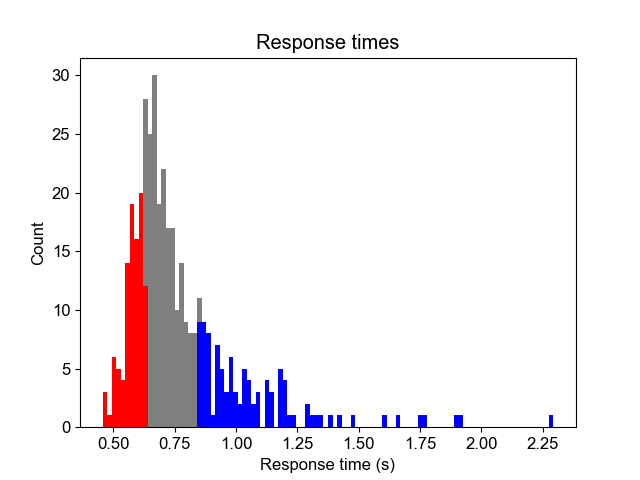

In [235]:
response_times = response_times_df['response_times'].values

# data_25 = np.quantile(response_times, 0.25)
# data_75 = np.quantile(response_times, 0.75)

bins = np.linspace(response_times.min(), response_times.max(), 101)

plt.figure()
plt.hist(response_times, bins=bins, color = 'k', alpha = 0.5)
plt.hist(response_times_df[response_times_df['trial_idx'].isin(trials_idx_25)]['response_times'], bins=bins, color = 'r')
plt.hist(response_times_df[response_times_df['trial_idx'].isin(trials_idx_75)]['response_times'], bins=bins, color = 'b')
plt.xlabel('Response time (s)')
plt.ylabel('Count')
plt.title('Response times');

import os
from os.path import join as pjoin
save_dir = '/Users/gabriel/Desktop/stimulus_response_scatters/movement_time'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# plt.savefig(pjoin(save_dir, 'response_time_25vs75.png'), format='png', dpi=300)
# plt.savefig(pjoin(save_dir, 'response_time_25vs75.svg'), format='svg', dpi=300)

In [236]:
def plot_scatter_panel(ax, x_data, y_data, xlabel, ylabel, x_err=None, y_err=None, highlight_idx=None):
    """Plot a scatter comparison with standard formatting and optional error bars and highlights."""
    # Regular scatter plot
    ax.errorbar(x_data, y_data, 
                xerr=x_err, yerr=y_err,
                fmt='o', color='black', alpha=0.2,
                ecolor='gray', elinewidth=1, capsize=2)
    
    # Add highlights if specified
    if highlight_idx is not None:
        ax.plot(x_data[highlight_idx], y_data[highlight_idx], 'o', 
                mfc='none', mec='red', ms=15, mew=2)
    
    min_val = min(np.min(x_data), np.min(y_data))
    max_val = max(np.max(x_data), np.max(y_data))
    ax.plot([min_val, max_val], [min_val, max_val], "k--", alpha=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="both", which="major")
    ax.set_aspect("equal")
    # separate_axes(ax)

In [237]:
valid_trials = trial_ts[trial_ts['trial_outcome'].isin([0,1])]

valid_trials = valid_trials[
            (valid_trials.movement_stims.apply(len) > 0) & 
            (valid_trials.stationary_stims.apply(len) > 0)
        ]

In [238]:
short_response_times = valid_trials[valid_trials.index.isin(trials_idx_25)]
long_response_times = valid_trials[valid_trials.index.isin(trials_idx_75)]

#### First stationary vs first movement scatters by movement time

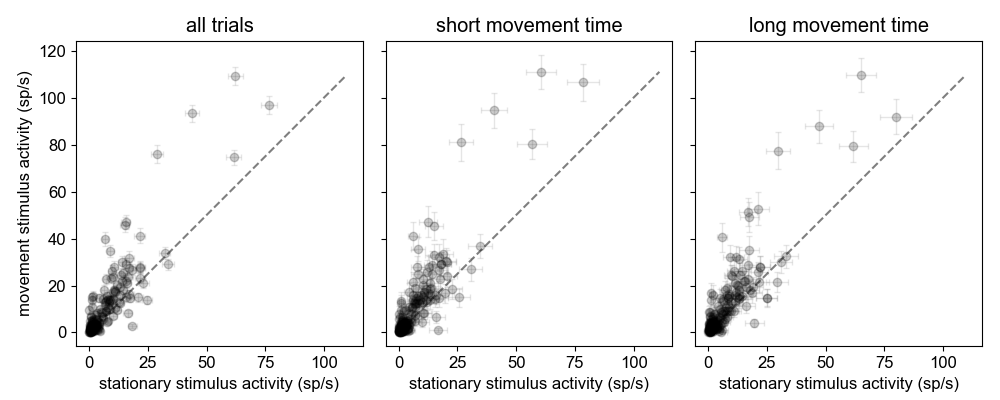

In [274]:
# Movement vs Stationary Analysis (Top Right)
movement_stims = np.array([stims[0] for stims in valid_trials.movement_stims])
stationary_stims = np.array([stims[0] for stims in valid_trials.stationary_stims])

pop_peth_move, timebin_edges_move, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=movement_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)
pop_peth_stat, _, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=stationary_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)

# Movement vs Stationary Analysis (Top Right)
short_movement_stims = np.array([stims[0] for stims in short_response_times.movement_stims])
short_stationary_stims = np.array([stims[0] for stims in short_response_times.stationary_stims])

pop_peth_short_move, timebin_edges_short_move, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=short_movement_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)
pop_peth_short_stat, _, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=short_stationary_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)

# Movement vs Stationary Analysis (Top Right)
long_movement_stims = np.array([stims[0] for stims in long_response_times.movement_stims])
long_stationary_stims = np.array([stims[0] for stims in long_response_times.stationary_stims])

pop_peth_long_move, timebin_edges_long_move, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=long_movement_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)
pop_peth_long_stat, _, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=long_stationary_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)

# Top Right: Movement vs Stationary Scatter
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)
stimulus_window = (timebin_edges_move[:-1] >= 0.04) & (timebin_edges_move[:-1] <= 0.1)
mean_peth_move = np.mean(pop_peth_move, axis=1)
mean_peth_stat = np.mean(pop_peth_stat, axis=1)
move_stimulus_response = np.mean(mean_peth_move[:, stimulus_window], axis=1)
stat_stimulus_response = np.mean(mean_peth_stat[:, stimulus_window], axis=1)

movement_modulation_idx = move_stimulus_response - stat_stimulus_response

move_sem = np.std(pop_peth_move[:, :, stimulus_window], axis=1) / np.sqrt(pop_peth_move.shape[1])
stat_sem = np.std(pop_peth_stat[:, :, stimulus_window], axis=1) / np.sqrt(pop_peth_stat.shape[1])
move_sem = np.mean(move_sem, axis=1)
stat_sem = np.mean(stat_sem, axis=1)

plot_scatter_panel(ax[0], stat_stimulus_response, move_stimulus_response,
                    "stationary stimulus activity (sp/s)", "movement stimulus activity (sp/s)",
                    x_err=stat_sem, y_err=move_sem)

short_stimulus_window = (timebin_edges_short_move[:-1] >= 0.04) & (timebin_edges_short_move[:-1] <= 0.1)
mean_peth_short_move = np.mean(pop_peth_short_move, axis=1)
mean_peth_short_stat = np.mean(pop_peth_short_stat, axis=1)
move_stimulus_response_short = np.mean(mean_peth_short_move[:, short_stimulus_window], axis=1)
stat_stimulus_response_short = np.mean(mean_peth_short_stat[:, short_stimulus_window], axis=1)

movement_modulation_idx_short = move_stimulus_response_short - stat_stimulus_response_short

move_sem_short = np.std(pop_peth_short_move[:, :, short_stimulus_window], axis=1) / np.sqrt(pop_peth_short_move.shape[1])
stat_sem_short = np.std(pop_peth_short_stat[:, :, short_stimulus_window], axis=1) / np.sqrt(pop_peth_short_stat.shape[1])
move_sem_short = np.mean(move_sem_short, axis=1)
stat_sem_short = np.mean(stat_sem_short, axis=1)

plot_scatter_panel(ax[1], stat_stimulus_response_short, move_stimulus_response_short,
                    "stationary stimulus activity (sp/s)", "movement stimulus activity (sp/s)",
                    x_err=stat_sem_short, y_err=move_sem_short)

long_stimulus_window = (timebin_edges_long_move[:-1] >= 0.04) & (timebin_edges_long_move[:-1] <= 0.1)
mean_peth_long_move = np.mean(pop_peth_long_move, axis=1)
mean_peth_long_stat = np.mean(pop_peth_long_stat, axis=1)
move_stimulus_response_long = np.mean(mean_peth_long_move[:, long_stimulus_window], axis=1)
stat_stimulus_response_long = np.mean(mean_peth_long_stat[:, long_stimulus_window], axis=1)

movement_modulation_idx_long = move_stimulus_response_long - stat_stimulus_response_long

move_sem_long = np.std(pop_peth_long_move[:, :, long_stimulus_window], axis=1) / np.sqrt(pop_peth_long_move.shape[1])
stat_sem_long = np.std(pop_peth_long_stat[:, :, long_stimulus_window], axis=1) / np.sqrt(pop_peth_long_stat.shape[1])
move_sem_long = np.mean(move_sem_long, axis=1)
stat_sem_long = np.mean(stat_sem_long, axis=1)

plot_scatter_panel(ax[2], stat_stimulus_response_long, move_stimulus_response_long,
                   "stationary stimulus activity (sp/s)", "movement stimulus activity (sp/s)",
                   x_err=stat_sem_long, y_err=move_sem_long)

ax[0].set_title('all trials')
# ax[0].set_ylim(0, 60)
# ax[0].set_xlim(0, 60)
ax[1].set_title('short movement time')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[2].set_title('long movement time')

plt.tight_layout()

save_dir = '/Users/gabriel/Desktop/stimulus_response_scatters/movement_time'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# plt.savefig(pjoin(save_dir, '25vs75_percentile.png'), format='png', dpi=300)
# plt.savefig(pjoin(save_dir, '25vs75_percentile.svg'), format='svg', dpi=300)

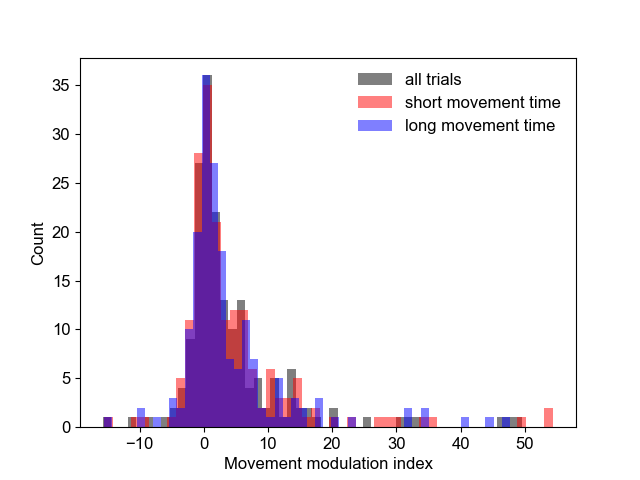

In [ ]:
plt.figure()
plt.hist(movement_modulation_idx, bins=50, color='k', alpha=0.5, label='all trials')
plt.hist(movement_modulation_idx_short, bins=50, color='r', alpha=0.5, label='short movement time')
plt.hist(movement_modulation_idx_long, bins=50, color='b', alpha=0.5, label='long movement time')
plt.xlabel('Movement modulation index')
plt.ylabel('Count')
plt.legend(frameon=False);

save_dir = '/Users/gabriel/Desktop/stimulus_response_scatters/movement_time/modulation_index'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# plt.savefig(pjoin(save_dir, '25vs75_movement_modulation_idx_hist.png'), format='png', dpi=300)

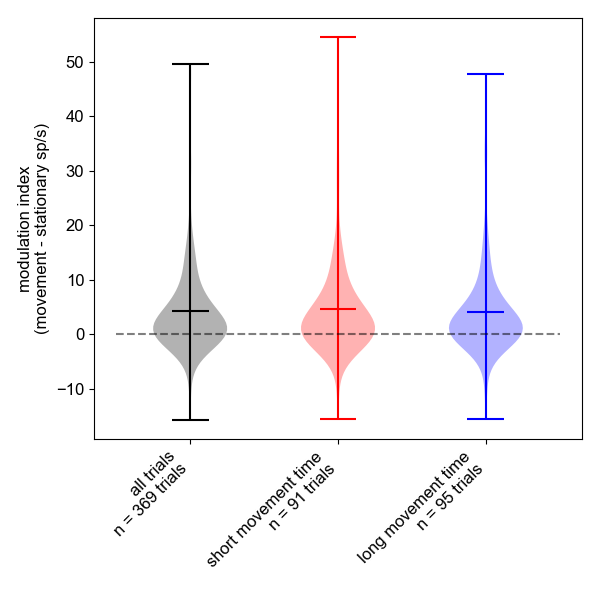

In [ ]:
data = [movement_modulation_idx, movement_modulation_idx_short, movement_modulation_idx_long]
fig, ax = plt.subplots(figsize=(6, 6))
parts = ax.violinplot(data, showmeans=True, showextrema=True)

colors = ['k', 'r', 'b']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    
if 'cbars' in parts:
    parts['cbars'].set_color(colors)
if 'cmins' in parts:
    parts['cmins'].set_color(colors)
if 'cmaxes' in parts:
    parts['cmaxes'].set_color(colors)
if 'cmedians' in parts:
    parts['cmedians'].set_color(colors)
elif 'cmeans' in parts:
    parts['cmeans'].set_color(colors)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels([f'all trials\nn = {movement_stims.shape[0]} trials', 
                    f'short movement time\nn = {short_movement_stims.shape[0]} trials', 
                    f'long movement time\nn = {long_movement_stims.shape[0]} trials'], rotation=45, ha='right')
ax.set_ylabel('modulation index\n(movement - stationary sp/s)')
ax.set_ylim(-20, 80)
ax.hlines(0, 0.5, 3.5, 'k', linestyle='--', alpha=0.5)
fig.tight_layout()
fig.savefig(pjoin(save_dir, '25vs75_movement_modulation_idx_violin.png'), format='png', dpi=300)


#### Plot against the last stationary instead of the first one

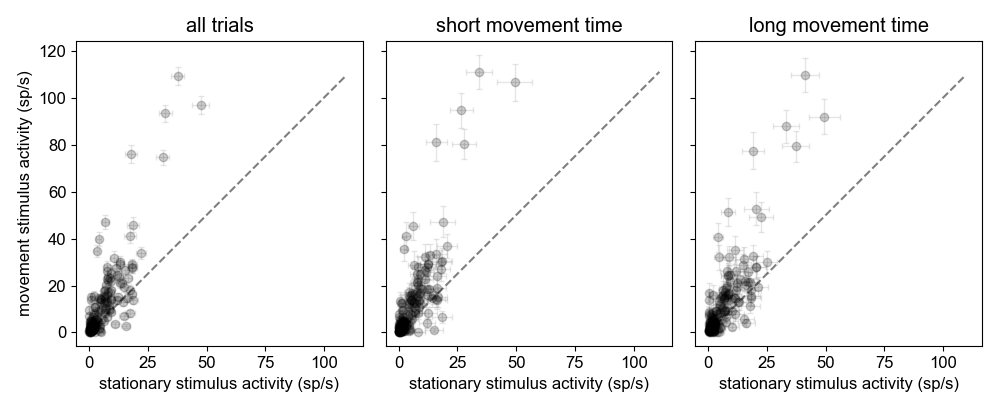

In [273]:
# Movement vs Stationary Analysis (Top Right)
movement_stims = np.array([stims[0] for stims in valid_trials.movement_stims])
stationary_stims = np.array([stims[-1] for stims in valid_trials.stationary_stims])

pop_peth_move, timebin_edges_move, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=movement_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)
pop_peth_stat, _, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=stationary_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)

# Movement vs Stationary Analysis (Top Right)
short_movement_stims = np.array([stims[0] for stims in short_response_times.movement_stims])
short_stationary_stims = np.array([stims[-1] for stims in short_response_times.stationary_stims])

pop_peth_short_move, timebin_edges_short_move, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=short_movement_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)
pop_peth_short_stat, _, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=short_stationary_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)

# Movement vs Stationary Analysis (Top Right)
long_movement_stims = np.array([stims[0] for stims in long_response_times.movement_stims])
long_stationary_stims = np.array([stims[-1] for stims in long_response_times.stationary_stims])

pop_peth_long_move, timebin_edges_long_move, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=long_movement_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)
pop_peth_long_stat, _, _ = population_peth(
    all_spike_times=spike_times_per_unit,
    alignment_times=long_stationary_stims,
    pre_seconds=0.025,
    post_seconds=0.15,
    binwidth_ms=10,
    pad=0,
    kernel=None,
)

# Top Right: Movement vs Stationary Scatter
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)
stimulus_window = (timebin_edges_move[:-1] >= 0.04) & (timebin_edges_move[:-1] <= 0.1)
mean_peth_move = np.mean(pop_peth_move, axis=1)
mean_peth_stat = np.mean(pop_peth_stat, axis=1)
move_stimulus_response = np.mean(mean_peth_move[:, stimulus_window], axis=1)
stat_stimulus_response = np.mean(mean_peth_stat[:, stimulus_window], axis=1)

movement_modulation_idx = move_stimulus_response - stat_stimulus_response

move_sem = np.std(pop_peth_move[:, :, stimulus_window], axis=1) / np.sqrt(pop_peth_move.shape[1])
stat_sem = np.std(pop_peth_stat[:, :, stimulus_window], axis=1) / np.sqrt(pop_peth_stat.shape[1])
move_sem = np.mean(move_sem, axis=1)
stat_sem = np.mean(stat_sem, axis=1)

plot_scatter_panel(ax[0], stat_stimulus_response, move_stimulus_response,
                    "stationary stimulus activity (sp/s)", "movement stimulus activity (sp/s)",
                    x_err=stat_sem, y_err=move_sem)

short_stimulus_window = (timebin_edges_short_move[:-1] >= 0.04) & (timebin_edges_short_move[:-1] <= 0.1)
mean_peth_short_move = np.mean(pop_peth_short_move, axis=1)
mean_peth_short_stat = np.mean(pop_peth_short_stat, axis=1)
move_stimulus_response_short = np.mean(mean_peth_short_move[:, short_stimulus_window], axis=1)
stat_stimulus_response_short = np.mean(mean_peth_short_stat[:, short_stimulus_window], axis=1)

movement_modulation_idx_short = move_stimulus_response_short - stat_stimulus_response_short

move_sem_short = np.std(pop_peth_short_move[:, :, short_stimulus_window], axis=1) / np.sqrt(pop_peth_short_move.shape[1])
stat_sem_short = np.std(pop_peth_short_stat[:, :, short_stimulus_window], axis=1) / np.sqrt(pop_peth_short_stat.shape[1])
move_sem_short = np.mean(move_sem_short, axis=1)
stat_sem_short = np.mean(stat_sem_short, axis=1)

plot_scatter_panel(ax[1], stat_stimulus_response_short, move_stimulus_response_short,
                    "stationary stimulus activity (sp/s)", "movement stimulus activity (sp/s)",
                    x_err=stat_sem_short, y_err=move_sem_short)

long_stimulus_window = (timebin_edges_long_move[:-1] >= 0.04) & (timebin_edges_long_move[:-1] <= 0.1)
mean_peth_long_move = np.mean(pop_peth_long_move, axis=1)
mean_peth_long_stat = np.mean(pop_peth_long_stat, axis=1)
move_stimulus_response_long = np.mean(mean_peth_long_move[:, long_stimulus_window], axis=1)
stat_stimulus_response_long = np.mean(mean_peth_long_stat[:, long_stimulus_window], axis=1)

movement_modulation_idx_long = move_stimulus_response_long - stat_stimulus_response_long

move_sem_long = np.std(pop_peth_long_move[:, :, long_stimulus_window], axis=1) / np.sqrt(pop_peth_long_move.shape[1])
stat_sem_long = np.std(pop_peth_long_stat[:, :, long_stimulus_window], axis=1) / np.sqrt(pop_peth_long_stat.shape[1])
move_sem_long = np.mean(move_sem_long, axis=1)
stat_sem_long = np.mean(stat_sem_long, axis=1)

plot_scatter_panel(ax[2], stat_stimulus_response_long, move_stimulus_response_long,
                   "stationary stimulus activity (sp/s)", "movement stimulus activity (sp/s)",
                   x_err=stat_sem_long, y_err=move_sem_long)

ax[0].set_title('all trials')
# ax[0].set_ylim(0, 60)
# ax[0].set_xlim(0, 60)
ax[1].set_title('short movement time')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[2].set_title('long movement time')

plt.tight_layout()

save_dir = '/Users/gabriel/Desktop/stimulus_response_scatters/movement_time/last_stationary'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# plt.savefig(pjoin(save_dir, '25vs75_percentile.png'), format='png', dpi=300)
# plt.savefig(pjoin(save_dir, '25vs75_percentile.svg'), format='svg', dpi=300)

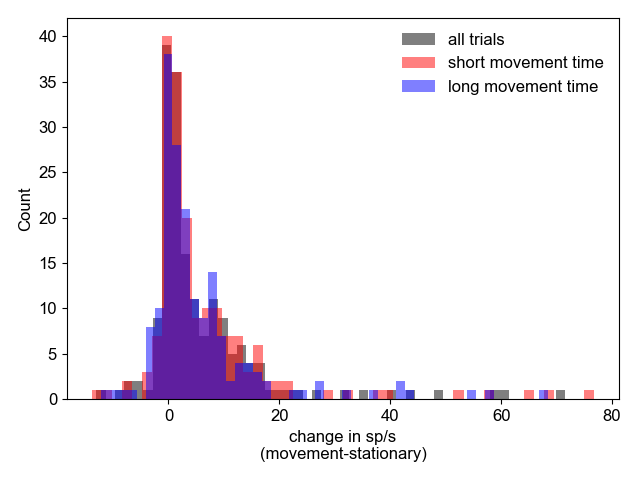

In [ ]:
plt.figure()
plt.hist(movement_modulation_idx, bins=50, color='k', alpha=0.5, label='all trials')
plt.hist(movement_modulation_idx_short, bins=50, color='r', alpha=0.5, label='short movement time')
plt.hist(movement_modulation_idx_long, bins=50, color='b', alpha=0.5, label='long movement time')
plt.xlabel('change in sp/s\n(movement-stationary)')
plt.ylabel('Count')
plt.legend(frameon=False)
plt.tight_layout()

save_dir = f'/Users/gabriel/Desktop/stimulus_response_scatters/movement_time/modulation_index/last_stationary'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(pjoin(save_dir, '25percent_movement_modulation_idx_hist.png'), format='png', dpi=300)

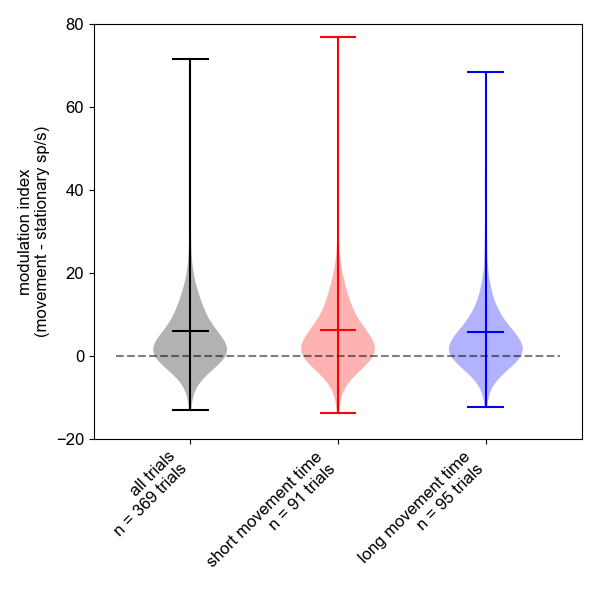

In [268]:
data = [movement_modulation_idx, movement_modulation_idx_short, movement_modulation_idx_long]
fig, ax = plt.subplots(figsize=(6, 6))
parts = ax.violinplot(data, showmeans=True, showextrema=True)

colors = ['k', 'r', 'b']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    
if 'cbars' in parts:
    parts['cbars'].set_color(colors)
if 'cmins' in parts:
    parts['cmins'].set_color(colors)
if 'cmaxes' in parts:
    parts['cmaxes'].set_color(colors)
if 'cmedians' in parts:
    parts['cmedians'].set_color(colors)
elif 'cmeans' in parts:
    parts['cmeans'].set_color(colors)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels([f'all trials\nn = {movement_stims.shape[0]} trials', 
                    f'short movement time\nn = {short_movement_stims.shape[0]} trials', 
                    f'long movement time\nn = {long_movement_stims.shape[0]} trials'], rotation=45, ha='right')
ax.set_ylabel('modulation index\n(movement - stationary sp/s)')
ax.set_ylim(-20, 80)
ax.hlines(0, 0.5, 3.5, 'k', linestyle='--', alpha=0.5)
fig.tight_layout()
fig.savefig(pjoin(save_dir, '25percent_movement_modulation_idx_violin.png'), format='png', dpi=300)
